Hidden states: [0. 0. 1. ... 1. 0. 0.]


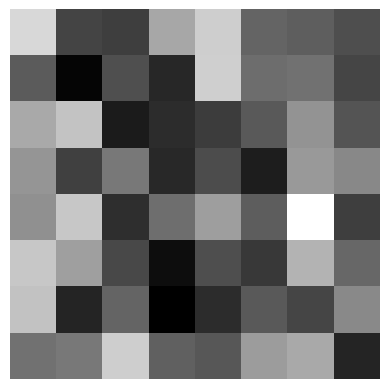

Hidden states: [0. 1. 1. ... 0. 1. 1.]


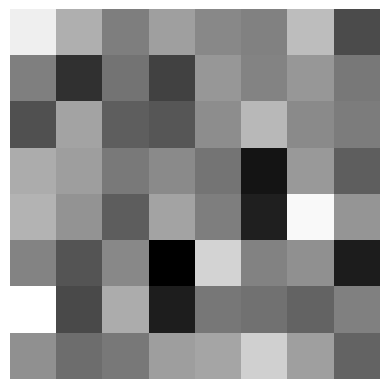

Hidden states: [1. 1. 0. ... 1. 1. 1.]


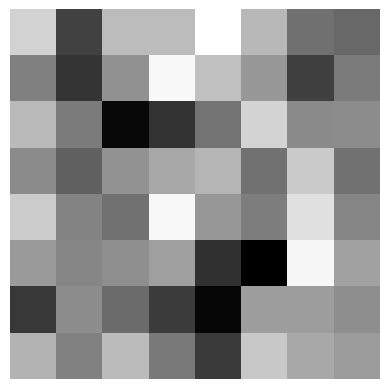

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class SimpleGenerativeNetwork(nn.Module):
    def __init__(self, n_hidden=2):
        super(SimpleGenerativeNetwork, self).__init__()
        
        # Define the size of our layers
        self.n_hidden = n_hidden        # Number of hidden units (features)
        self.image_size = 8             # We'll generate 8x8 images
        self.n_visible = 64             # 8x8 = 64 pixels
        
        # This layer transforms our hidden units into pixel probabilities
        # Each hidden unit will influence every pixel in the output
        self.generative_layer = nn.Linear(n_hidden, self.n_visible)
        
        # This layer helps us infer hidden unit states from images
        # It's the opposite direction of the generative layer
        self.recognition_layer = nn.Linear(self.n_visible, n_hidden)
        
        # Sigmoid activation to convert numbers into probabilities
        self.sigmoid = nn.Sigmoid()

    def generate(self, hidden_states):
        """Generate an image from hidden unit states"""
        # Convert hidden states into pixel probabilities
        pixel_probs = self.sigmoid(self.generative_layer(hidden_states))
        
        # Reshape into a square image
        return pixel_probs.view(-1, 8, 8)
    
    def infer_hidden(self, images):
        """Infer probable hidden unit states from an image"""
        # Flatten the image
        flat_images = images.view(-1, self.n_visible)
        
        # Compute probabilities for hidden units
        hidden_probs = self.sigmoid(self.recognition_layer(flat_images))
        return hidden_probs

    def sample_hidden(self):
        """Generate random hidden unit states"""
        # Each hidden unit has 0.5 probability of being active
        return torch.bernoulli(torch.ones(1, self.n_hidden) * 0.5)

# Create the network
net = SimpleGenerativeNetwork(n_hidden=2500)

# Function to display an image
def show_image(img):
    plt.imshow(img.detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

# Generate and show some examples
for _ in range(3):
    # Sample random hidden states
    hidden_states = net.sample_hidden()
    
    # Generate an image
    generated_image = net.generate(hidden_states)
    
    # Show the image and the hidden states that created it
    print(f"Hidden states: {hidden_states.numpy().flatten()}")
    show_image(generated_image[0])


In [7]:
test_image = torch.zeros(1, 8, 8)
test_image[:, :, 3:5] = 1  # Create a vertical line in the middle

# Infer hidden states
hidden_probs = net.infer_hidden(test_image)
print("\nInferred hidden states for vertical line:", hidden_probs.detach().numpy().flatten())



Inferred hidden states for vertical line: [0.50377786 0.4542027  0.52043    ... 0.56939816 0.39723423 0.515862  ]


Epoch 200, Loss: 0.1875
Epoch 400, Loss: 0.1875
Epoch 600, Loss: 0.1875
Epoch 800, Loss: 0.1875
Epoch 1000, Loss: 0.1875

After training:

Pattern for hidden unit 1:


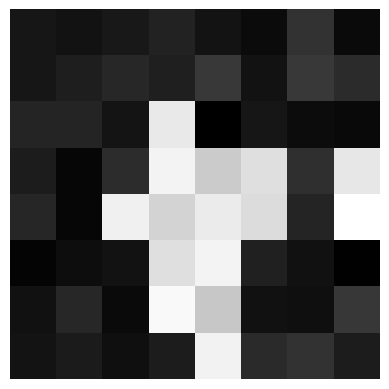


Pattern for hidden unit 2:


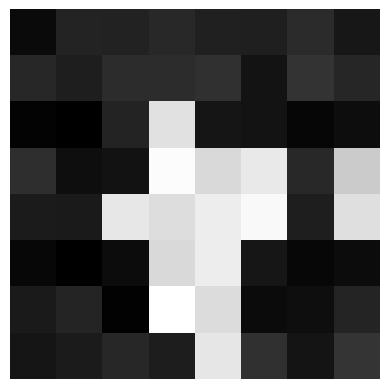

In [12]:

# Let's train the network to generate some simple patterns
optimizer = optim.Adam(net.parameters(), lr=0.1)

# Create training data: vertical and horizontal lines
vertical_line = torch.zeros(1, 8, 8)
vertical_line[:, :, 3:5] = 1

horizontal_line = torch.zeros(1, 8, 8)
horizontal_line[:, 3:5, :] = 1

training_data = torch.stack([vertical_line, horizontal_line])

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    
    # Try to reconstruct the training images
    hidden_states = net.infer_hidden(training_data)
    reconstructed = net.generate(hidden_states)
    
    # Compute reconstruction loss
    loss = nn.MSELoss()(reconstructed, training_data)
    
    # Update weights
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

# Show what we learned
print("\nAfter training:")
for i in range(2):
    # Create a hidden state with only one unit active
    hidden = torch.zeros(1, net.n_hidden)
    hidden[0, i] = 1
    
    # Generate and show the pattern this hidden unit learned
    pattern = net.generate(hidden)
    print(f"\nPattern for hidden unit {i+1}:")
    show_image(pattern[0])